In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('../')
from package_global_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

# same function as in plot_evos.py
def getTimeEvosPath():
    extSSDpath = getExternalSSDpath()
    if os.path.exists(extSSDpath):
        path = extSSDpath + getProjectFoldername() + '/evo_to_stationary/time_evos_dif_cond'
    else:
        path = '/time_evos_dif_cond'
    return path

In [2]:
N, pi1, pi2, q1, q2, l = 5000, 0.1, 0.1, 9, 10, 0.3
# get the dataframes with the time evolutions:
folder = f'time_evo_csv_N_{N}_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}'
files = glob.glob(f'{getTimeEvosPath()}/{folder}/*')
dfs = [pd.read_csv(file) for file in files]

In [3]:
def expo(t,a,b):
    return a*np.exp(-b*t)

def poly_decay(t,a,b):
    return a*t**b

def poly_decay_jac(t,a,b):
    a0 = t**b
    a1 = a*t**b*np.log(t)
    return np.array([a0,a1]).T

Average stationary time 24.314892924130408 +- 6.413062499198958


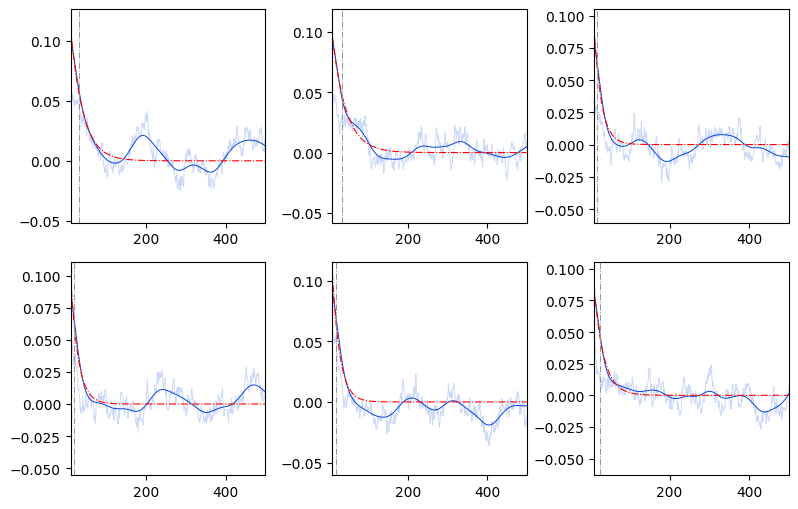

In [12]:
fig, ax = plt.subplots(2,3, figsize=(8.0, 5.2))
dfs2 = [[dfs[0], dfs[1], dfs[2]], [dfs[3], dfs[4], dfs[5]]]
times = []
for i in range(2):
    for j in range(3):
        # statf0, statf1, statf2 = np.average(dfs2[i][j]['f0'][1000:]), np.average(dfs2[i][j]['f1'][1000:]), np.average(dfs2[i][j]['f2'][1000:])
        statf2 = np.average(dfs2[i][j]['f2'][1000:])
        dfs2[i][j]['decay'] = -dfs2[i][j]['f2']+statf2
        dfs2[i][j]['decay_filtered'] = gaussian_filter1d(dfs2[i][j]['decay'], sigma=20)
        ax[i,j].plot(dfs2[i][j]['iter'], dfs2[i][j]['decay'], lw=0.7, color='xkcd:blue', alpha=0.2)
        ax[i,j].plot(dfs2[i][j]['iter'], dfs2[i][j]['decay_filtered'], lw=0.7, color='xkcd:blue')
        # ax[i,j].plot(dfs2[i][j]['iter'], dfs2[i][j]['f1'], lw=0.7, color='xkcd:green')
        ax[i,j].set(xlim=(10,500), ylim=(None,dfs2[i][j]['decay_filtered'][10]+0.025))
        tfrom, to = 10, 500
        time, data = dfs2[i][j]['iter'][tfrom:to], dfs2[i][j]['decay_filtered'][tfrom:to]
        paramfit, covfit = curve_fit(expo,time,data,p0=(statf2, 0.001))
        fit = expo(time, *paramfit)
        ax[i,j].plot(time, fit, ls='-.', color='r', lw=0.8)
        time = 1/paramfit[1]
        # time = search_time(w, t, dfs2[i][j]['f2'])
        times.append(time)
        ax[i,j].axvline(time, lw=0.7, color='xkcd:gray', ls='-.')
print(f'Average stationary time {np.average(times)} +- {np.std(times)}')
fig.tight_layout()
fig.savefig(f'time_decay_to_stat_N_{N}_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}.png')

[0.298607   0.01077862]


[(9.0, 500.0)]

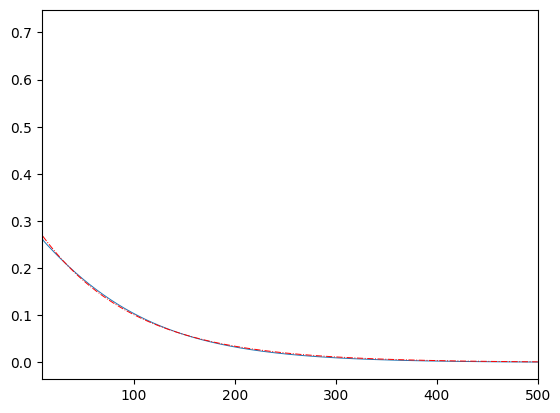

In [97]:
# try to fit to the Euler integrated evolution:

intEvoFile = f'/time_evo_csv_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}_Euler.csv'
intEvo = pd.read_csv(f'{getTimeEvosPath()}/{intEvoFile}')
sols = [intEvo.iloc[-1][f'f{i}'] for i in range(3)]
intEvo['f2_minusStat'] = sols[2] - intEvo['f2']

fig, ax = plt.subplots()
ax.plot(intEvo['iter'], intEvo['f2_minusStat'], lw=0.7)

tfrom, to = 10, 500
time, data = np.array(intEvo['iter'])[tfrom:to+1], np.array(intEvo['f2_minusStat'])[tfrom:to+1]
paramfit, covfit = curve_fit(expo,time,data,p0=(0.7, 0.001))
fit = expo(time, *paramfit)
# paramfit, covfit = curve_fit(poly_decay,time,data,jac=poly_decay_jac)
# fit = poly_decay(time, *paramfit)
ax.plot(time, fit, ls='-.', color='r', lw=0.7)
print(paramfit)


ax.set(xlim=(9,500))

In [58]:
sols[2]**2

0.5078952540460969

(10.0, 20.0)

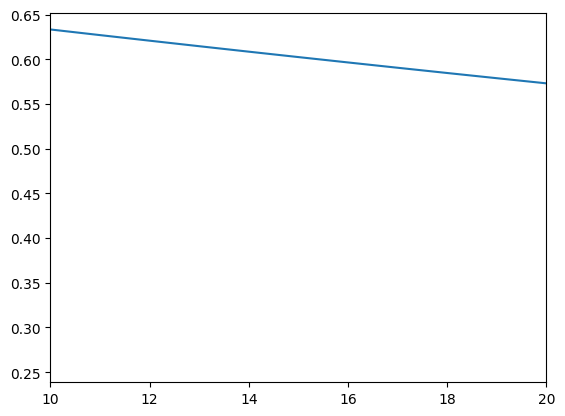

In [88]:
fig, ax = plt.subplots()
ax.plot(time, 0.7*np.exp(-0.01*time))
ax.set_xlim(xmin=10, xmax=20)